# Author
David Dada  

# Decision Tree from Scratch

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure. 


![image.png](decistion_tree.png)
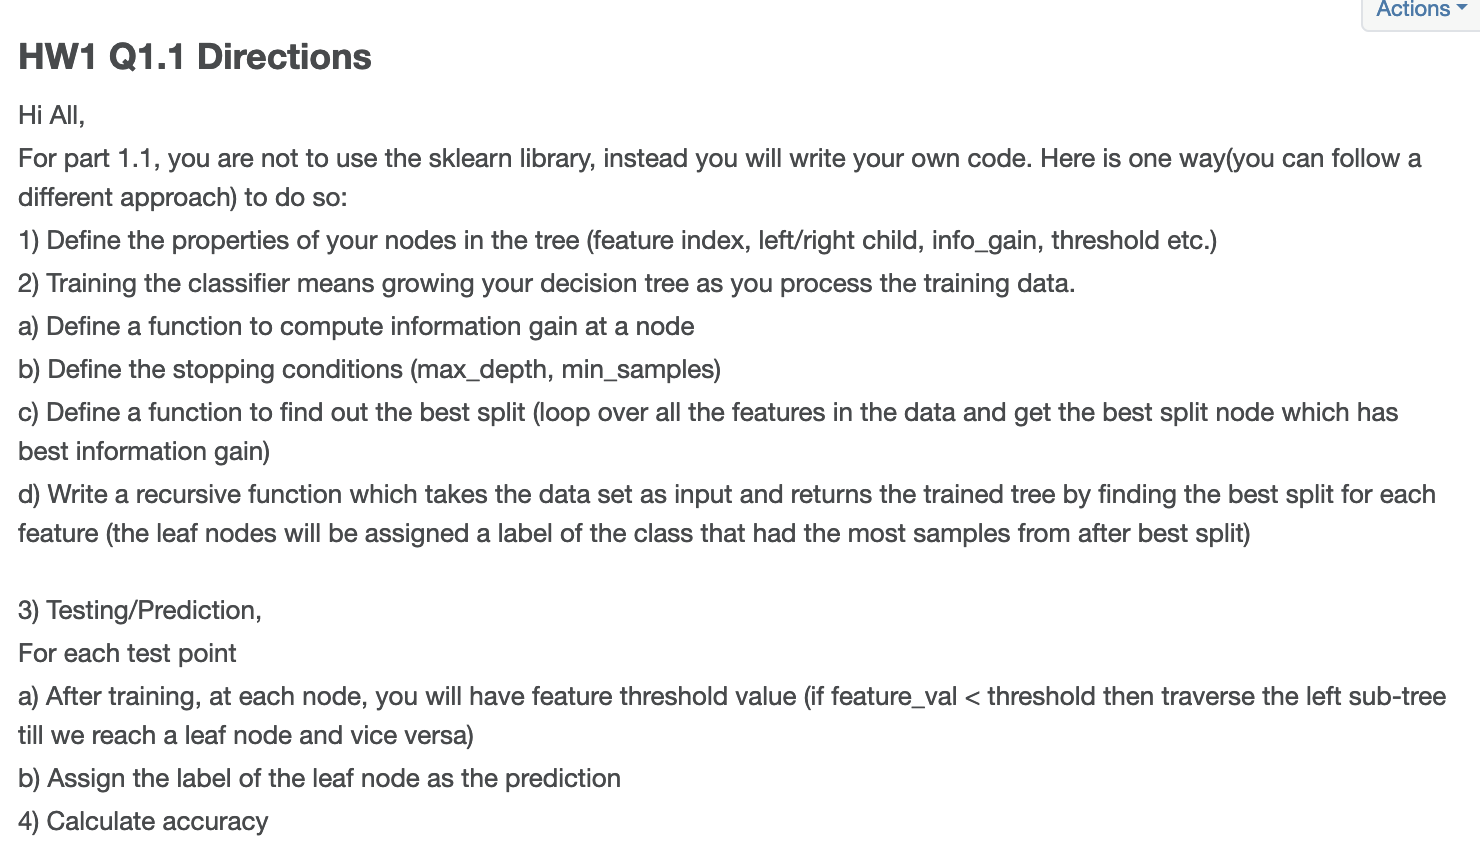

# Assumptions
## Dataset
it is assumed that the dataset pre-processed such that each row has values, and are of the exact same length whereby each feature is defined by each column and the right-most column is the class/target value

#### Headers
it is assumed that the dataset first row will always be the title headers of the columns, and as such that row is skipped in calculation

## Node Structure

### Leaf Nodes
we will only be splitting nodes into two sub-nodes
For an arbitrary split s, we can say that left child L < s and right child R ≥ s

# Conclusion
I was able to get a 97.33% accuracy with the training set.
The training set was the first half of the dataset and the test data was the second half

In [2]:
# Imports
import numpy as np
from enum import Enum
import math as math

np.set_printoptions(formatter={'float_kind':lambda x: "%2.1f" %x})

In [3]:
# Dataset
data = np.loadtxt('data.csv', delimiter=',', skiprows=1)
feature_headers = ['feature1','feature2','feature3','feature4']
class_labels = [0,1,2]

# Train & Test data
train_test_ratio = 0.5 # % of data that will be for training, divided sequentially
split  = math.floor(train_test_ratio * len(data))

train = data[:split]
test = data[split:]

# Model: Design Matrix, Feature array
X = train[:,:-1]
y = train[:,-1]

# test data
X_test = test[:,:-1]
y_test = test[:,-1]

# y formatted as a 2D array, needed for some calculations
y2D = list(map(lambda y: [y], y))

In [6]:
## Helper functions
# print formatted np array
def printNPArr(array):
    print(np.array2string(array, separator=", "))

# print formatted regular array
def printArr(array):
    printNPArr(np.matrix(array))
    
# split samples on the threshold of a feature
def split_samples(_samples, feature, threshold):
    left = []
    right = []
    
    for sample in _samples:
        if sample[feature] < threshold:
           left.append(sample)
        else:
            right.append(sample)
    return np.array(left), np.array(right)

def best_split(dataset, features):
    best_split_feature_index = None;
    best_split_threshold = None
    max_information_gained = float('-inf');

    # loop from index 0 to len-1 which is assumed over all features
    for feature in range(features):
        for threshold in unique_feature_range(dataset, feature):
            threshold = round(threshold, 2)
            samples = split_samples(dataset, feature, threshold)
            info_gained = information_gained(dataset, samples[0], samples[1])

            if(info_gained > max_information_gained):
                max_information_gained = info_gained
                best_split_feature_index = feature
                best_split_threshold = threshold

    return best_split_feature_index, best_split_threshold

# feature value range. Gets a sorted list of column values
def unique_feature_values(samples, feature):
    return sorted(set(samples[:,feature]))

# range of all values from min to max to try to split on. increment by 0.1
def unique_feature_range(samples, feature):
    all_samples = samples[:,feature]
    return np.arange(math.floor(min(all_samples)), math.ceil(max(all_samples)), 0.1)

# entropy calculation    
def entropy(y):
    y = y.tolist()
    entropy = 0
    total = len(y)
    classLabels = sorted(set(y))
    
    for classLabel in classLabels:
        classCount = y.count(classLabel)
        probability = classCount/total
        entropy -= probability * np.log2(probability)

    return entropy

# value of a dataset is the count of each class
def dataset_value(y):
    y = y.tolist()
    classLabels = class_labels # manually defined
    return list(map(lambda label: y.count(label), classLabels))


# expected entropy
def expected_entropy(_left, _right):
    left = len(_left)
    right = len(_right)
    total = left + right
    expected_entropy = 0
    
    if total == 0:
        return 0
    
    # as to not try and [:,-1] a 1D matrix
    if left > 0:
        expected_entropy += ((left/total) * entropy(_left[:,-1]))
        
    if right > 0:
       expected_entropy += ((right/total) * entropy(_right[:,-1]))
    
    return expected_entropy

# information gained calculation
def information_gained(parent, left, right):
    return entropy(parent[:,-1]) - expected_entropy(left, right)

def print_nodes(node, depth = 0, prefix = ""):
    """
    Visually Print the nodes
    """
    if node == None:
        return
    if node.value == None:
        return
    
    indent = depth * "     "
    print(indent, '----------')
    print(indent, 'depth: ', depth)
    print(indent, prefix, node.value)
    print(indent, "X " + str(node.feature_index), "<", node.threshold, "?", node.info_gain)            
    print(indent, '----------\n')
    
    print_nodes(node.left, depth + 1, "Left")
    print_nodes(node.right, depth + 1, "Right")

# accuracy of predictions. percentage of correct labels
def accuracy(y_hat, y):
    correct = 0
    total = len(y)
    
    if total == 0 or total != len(y_hat):
        return None

    for i in range(total):
        if y_hat[i] == y[i]:
            correct+=1
    return correct/total

In [7]:
## Data Structures

# the information gain selection between Entropy and Gini index
class InformationGainMode(Enum):
    Entropy = 1
    Gini = 2

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # Start code here
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value
    # End code here        
        
class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=5):
        # Initialize the root of the decision tree to traverse through the decision tree to None
        self.root = None
        # initialize the stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        """
        This will be a recursive function to build the decision tree.
        dataset: The data that you will be using for your assignment
        curr_depth: Current depth of the tree
        Returns the leaf node
        """
        
        if(len(dataset) == 0):
            return Node()
        
        # Separate the features and targets into two variables X and y
        X = dataset[:, :-1]
        y = dataset[:,-1]

        # Extract the number of samples and number of features
        num_samples = len(X)
        num_features = len(X[0])
        
        # split until stopping conditions are met
        feature_index, threshold = self.get_best_split(dataset, num_features)
        
        # compute leaf node
        left, right = self.split(dataset, feature_index, threshold)
        
        info_gain = self.information_gain(dataset, left, right, mode=InformationGainMode.Entropy)
        
        # node value is the count of each sample class in a set
        value = self.calculate_leaf_value(y)
        
        node = Node(feature_index=feature_index, threshold=threshold, info_gain=info_gain, value=value)
        
        # recursively build child nodes should constraints be met
        if curr_depth < self.max_depth and len(left) > self.min_samples_split and len(right) > self.min_samples_split:
            node.left = self.build_tree(dataset = left, curr_depth = curr_depth + 1)
            node.right = self.build_tree(dataset = right, curr_depth = curr_depth + 1)

        # return the leaf node
        return node

    def get_best_split(self, dataset, num_features):
        """
        Function to find out the best split
        dataset: input data
        num_samples: Number of samples present in the dataset
        num_features: Number of features in the dataset
        Returns the best split
        """
        return best_split(dataset, num_features)

    def split(self, dataset, feature_index, threshold):
        """
        Function to split the data to the left child and right child in the decision tree
        dataset: input data
        feature_index: feature index used to locate the index of the feature in a particular row in the dataset
        threshold: threshold value based on which the split will be calculated
        Returns the left and right datavalues from the dataset
        """
        # Hint: Use list comprehension to distinguish which values would be present in left and right
        # subtree on the basis of threshold
        return split_samples(dataset, feature_index, threshold)

    def information_gain(self, parent, l_child, r_child, mode=InformationGainMode.Entropy):
        """
        Function to calculate information gain. This function subtracts the combined information
        of the child node from the parent node.
        parent: value of parent node
        l_child: value of left child node
        r_child: value of right child node
        mode: based on which information gain will be calculated either entropy/gini index
        Returns the information gain
        """
        
        if(mode == InformationGainMode.Entropy):
            return information_gained(parent, l_child, r_child)
        else:
            # Gini index
            return information_gained(parent, l_child, r_child)

    def entropy(self, y):
        """
        Function to calculate the entropy
        y: target labels
        Returns entropy
        """
        return entropy(y)

    def gini_index(self, y):
        """
        Function to calculate gini index
        y: target labels
        Returns gini index
        """
        return 1 - gini

    def calculate_leaf_value(self, y):
        """
        Function to compute the value of leaf node.Return the most occurring 
        element in Y. Hint: you can use lists
        Y: target labels
        Returns leaf node value
        """
        return dataset_value(y)

    def print_tree(self, tree=None, indent=" "):
        """
        Function to print the tree. Use the pre-order traversal method to print the decision tree.
        # Do not make any changes in this function
        """

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X " + str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end=" ")
            self.print_tree(tree.left, indent + indent)
            print("%sright" % (indent), end=" ")
            self.print_tree(tree.right, indent + indent)
            
    def display_tree(self, tree=None, indent=" "):
        if tree is None or tree.value is None:
            return
        else:
            print(tree.value)
            print("X " + str(tree.feature_index), "<", tree.threshold, "?", tree.info_gain)            
        
        if tree.left is not None:
            print("%sleft:" % (indent), end=" ")
            self.display_tree(tree.left, indent + indent)
            
        if tree.right is not None:            
            print("%sright" % (indent), end=" ")
            self.display_tree(tree.right, indent + indent)   
            
    def print_tree_detailed(self):
        """
        Prints the tree recursively in pre-order traversal.
        Includes current depth of the tree
        """
        print_nodes(self.root)
        
    def fit(self, X, Y):
        """
        Function to train the tree.
        X: Features
        Y: Target
        """
        # Concatenate X, Y to create the dataset and call the build_tree function recursively
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def predict(self, X):
        """
        Prediction function to calculate the all the predictions of the matrix of features
        provided using make_predictions function
        X: Matrix of features
        Returns predictions
        """
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions

    def make_predictions(self, x, tree):
        """
        Function to predict a single datapoint
        """
        # if leaf node
        if tree.left is None and tree.right is None:
            max_value = max(tree.value)
            return tree.value.index(max_value)
        
        # if less than threshold
        if x[tree.feature_index] < tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)

In [8]:
dtree = DecisionTreeClassifier()
dtree.fit(X, y2D)

# Predictions and accuracy
y_hat = dtree.predict(X_test)
print("Decision tree accuracy: ", round(accuracy(y_hat, y_test) * 100, 4), '%\n')

# Print the tree
dtree.print_tree_detailed()

Decision tree accuracy:  97.3333 %

 ----------
 depth:  0
  [26, 23, 26]
 X 2 < 2.0 ? 0.9310558233850331
 ----------

      ----------
      depth:  1
      Left [26, 0, 0]
      X 0 < 4.0 ? 0.0
      ----------

      ----------
      depth:  1
      Right [0, 23, 26]
      X 3 < 1.8 ? 0.610470456057157
      ----------

           ----------
           depth:  2
           Left [0, 23, 5]
           X 2 < 5.0 ? 0.33608223214775856
           ----------

                ----------
                depth:  3
                Left [0, 22, 1]
                X 0 < 5.0 ? 0.2580186686648155
                ----------

                ----------
                depth:  3
                Right [0, 1, 4]
                X 3 < 1.7 ? 0.7219280948873623
                ----------

           ----------
           depth:  2
           Right [0, 0, 21]
           X 0 < 5.0 ? 0.0
           ----------


# Decision Tree using Sklearn Benchmarking

### Conclusion
what was different in the sklearn vs. my custom implementation was the constraints of the table such as minimum viable split and also tree depth which can lead to slightly different outcomes.

Another difference is that sklearn threshold precision is to 2 decimal places while my custom implementation was only 1 decimal place.

overall the tree was quite similar and the accuracy for the sklearn was between 94.67% to 98.67%.

The sklearn tree root sometimes split on feature4 at a 0.75 threshold or feature3 at  2.45 threshold whereas my implementation always spits at feature3 at threshold 2.0 but in effect this resulted in the exact same split of data at the root node.

In [11]:
# Imports
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score

Decision tree accuracy:  98.6667 %


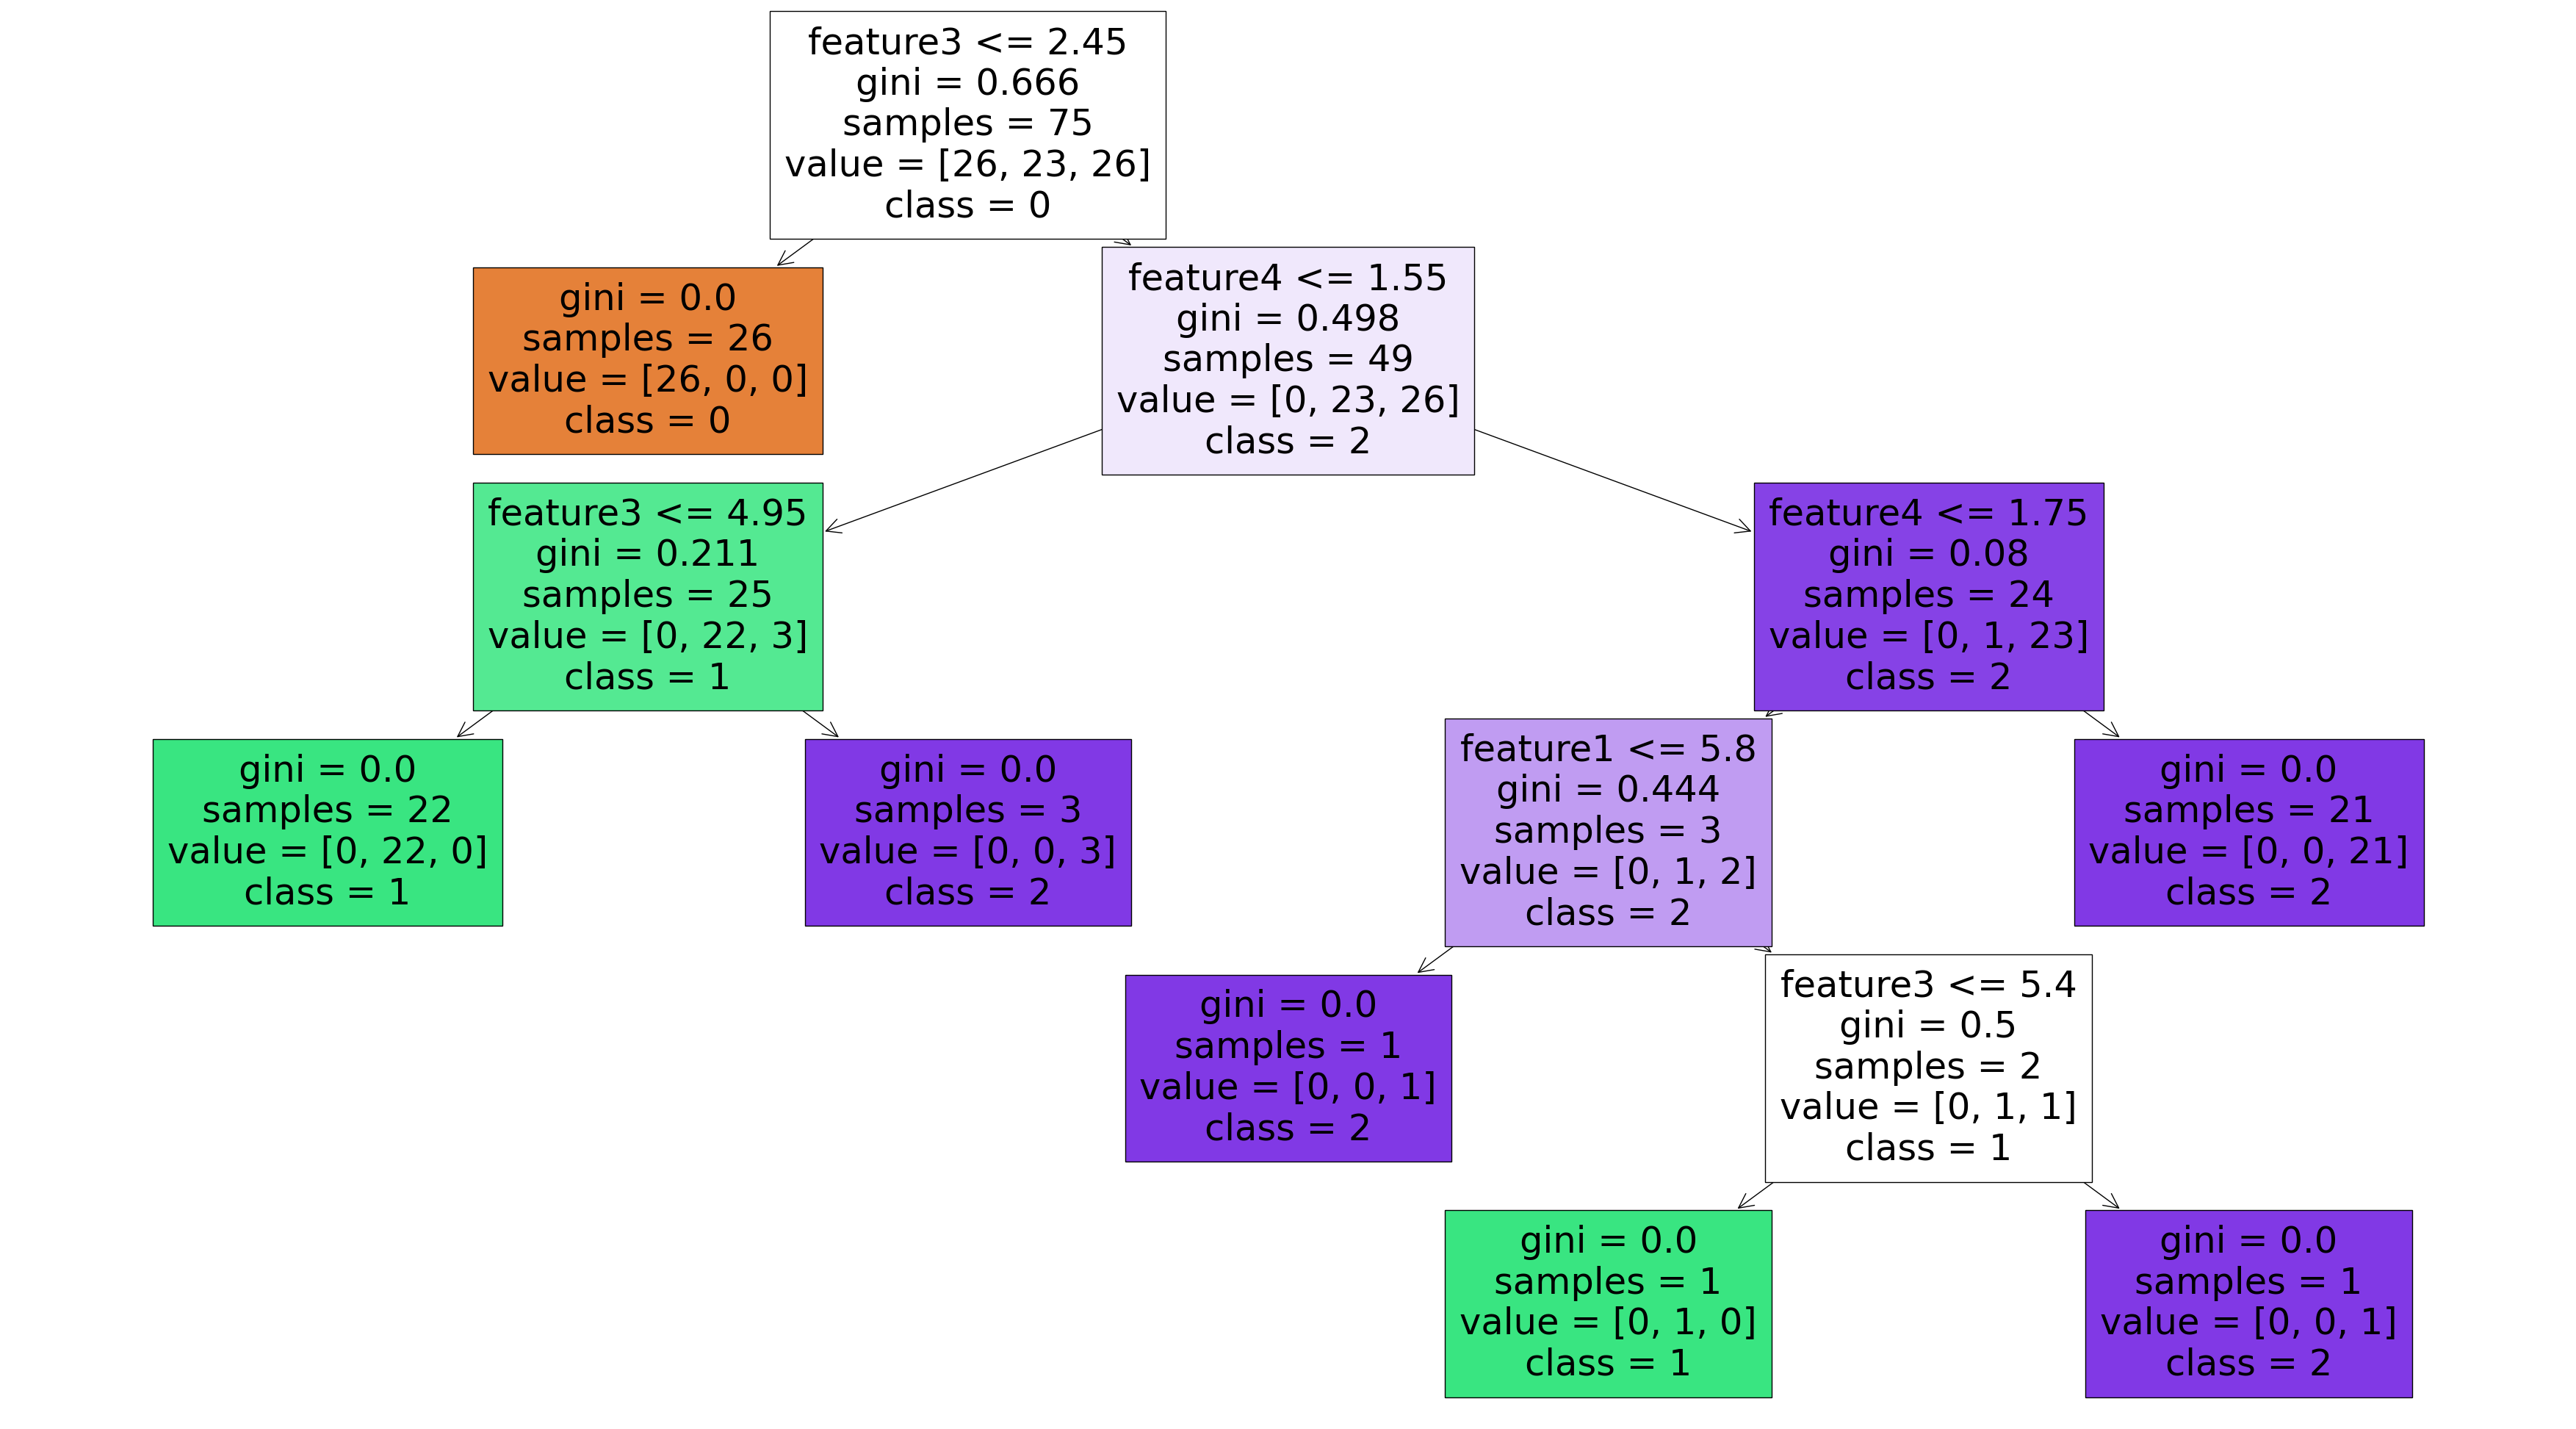

In [12]:
clf = DecisionTreeClassifier(criterion='gini')
model = clf.fit(X, y2D)

# Predictions and accuracy
y_hat = clf.predict(X_test)
accuracy = accuracy_score(y_hat, y_test)
print("Decision tree accuracy: ", round(accuracy * 100, 4), '%\n')

# Display tree
fig = plt.figure(figsize=(45,25))
_ = tree.plot_tree(clf, 
                   feature_names=feature_headers,  
                   class_names=list(map(lambda x: str(x), class_labels)),
                   filled=True)